# Estimating the number of EV registrations

## Purpose
Estimate the number of EV registrations by ZIP code, taking into account socioeconomic factors such as population, number of households, median income, and education level.

To be used in a larger project at [CALSTART](https://calstart.org/).

# Outline
- [1 - Packages](#1)
- [2 - Import data & clean](#2)
- [Note - Limitations of spatial analysis using ZIP codes](#0)

## Data set

This data set is compiled from the Census Bureau's American Community Survey (2021) and the Department of Motor Vehicles from select states as sourced by [Atlas EV Hub](https://www.atlasevhub.com/materials/state-ev-registration-data/).
- 33774 Total ZIP codes
- 27299 ZIP codes without EV registration
-  6475 ZIP codes with EV registration

Dataset is a 33774x32 matrix, with columns (0 to 31)

|Column| Variable List | Description |
| :- | :- | --- |
| 0 | zip | ZIP code |
| 1 | evs_reg | number of EVs registered in 2022 |
| 2 | tot_pop | total population |
| 3 | tot_pop_16up | total population of 16 y/o and up |
| 4 | tot_pop_18up | total population of 18 y/o and up |
| 5 | num_house | number of households |
| 6 | med_income | median income by household |
| 7 | per_10k_income | \% of households earning less than \\$10,000 |
| 8 | per_15k_income | \% of Households Earning \\$10,000 to \\$14,999 |
| 9 | per_25k_income | \% of Households Earning \\$15,000 to \\$24,999 |
| 10 | per_35k_income | \% of Households Earning \\$25,000 to \\$34,999 |
| 11 | per_50k_income | \% of Households Earning \\$35,000 to \\$49,999 |
| 12 | per_75k_income | \% of Households Earning \\$50,000 to \\$74,999 |
| 13 | per_100k_income | \% of Households Earning \\$75,000 to \\$99,999 |
| 14 | per_150k_income | \% of Households Earning \\$100,000 to \\$149,999 |
| 15 | per_200k_income | \% of Households Earning \\$150,000 to \\$199,999 |
| 16 | per_200kup_income | \% of Households Earning \\$200,000 or more |
| 17 | pop_18_24 | Population 18 to 24 years |
| 18 | pop_18_24_nohs | 18 to 24 years - Less than high school graduate |
| 19 | pop_18_24_hsgrad | 18 to 24 years - High school graduate (includes equivalency) |
| 20 | pop_18_24_adgrad | 18 to 24 years - Some college or associate's degree |
| 21 | pop_18_24_bsup| 18 to 24 years - Bachelor's degree or higher |
| 22 | pop_25up | Population 25 years and over |
| 23 | pop_25up_no | 25 years and over - Less than 9th grade |
| 24 | pop_25up_nohs | 25 years and over - 9th to 12th grade, no diploma |
| 25 | pop_25up_hsgrad | 25 years and over - High school graduate (includes equivalency) |
| 26 | pop_25up_some | 25 years and over - Some college, no degree |
| 27 | pop_25up_adgrad | 25 years and over - Associate's degree |
| 28 | pop_25up_bsgrad | 25 years and over - Bachelor's degree |
| 29 | pop_25up_grad | 25 years and over - Graduate or professional degree |
| 30 | pop_25up_hsup | 25 years and over - High school graduate or higher |
| 31 | pop_25up_bsup | 25 years and over - Bachelor's degree or higher |

<a name='1'></a>
## 1 - Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions.EV_utilities import plot_loss
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

# reduce display precision on numpy arrays
np.set_printoptions(precision=2)

<a name='2'></a>
## 2 - Import data & clean
Separate into training (with evs_reg) & testing sets (without evs_reg)

In [22]:
# read in all data frames
df = pd.read_csv('C:\\Users\\Stephen\\Documents\\GitHub\\EV-registration\\EV_orig_data.csv')
df_race = pd.read_csv('C:\\Users\\Stephen\\Documents\\GitHub\\EV-registration\\EV_race_2020.csv')
df_sex  = pd.read_csv('C:\\Users\\Stephen\\Documents\\GitHub\\EV-registration\\EV_sex_2020.csv')
df_tran = pd.read_csv('C:\\Users\\Stephen\\Documents\\GitHub\\EV-registration\\EV_tran_2020.csv')

# remove extraneous columns from df_race and merge 
df_race = df_race.drop(columns='tot_pop')
df = pd.merge(df,df_race, on='zip', how='left')
del df_race

# replace missing data in df_sex with Nan and merge
df_sex.replace('-', np.nan, inplace=True)
df = pd.merge(df,df_sex, on='zip', how='left')
del df_sex

# merge df_tran 
df = pd.merge(df,df_tran, on='zip', how='left')
del df_tran

# ensure zip column has leading zeros by converting number (with no numeric value) to a string
df['zip'] = df['zip'].astype(str).str.zfill(5)

# create training data by dropping rows with NaN in 'eve_reg' column
temp_training_data = df.dropna(subset=['evs_reg'])
# refine training data by dropping more rows (~400) with missing values in any other columns
train_data = temp_training_data.dropna()
# remove zip column
train_data = train_data.drop(['zip'], axis=1)
# reset index
train_data = train_data.reset_index(drop=True)

# create testing data subsetting were 'evs_reg' has no value
temp_testing_data  = df[df['evs_reg'].isna()]
# drop 'zip' and 'evs_reg' columns, and any rows with NA
test_data = temp_testing_data.drop(['zip','evs_reg'],axis=1)
test_data = test_data.dropna()
# reset index
test_data = test_data.reset_index(drop=True)

#### visualize the training data:

In [23]:
train_data

,evs_reg,tot_pop,tot_pop_16up,tot_pop_18up,num_house,med_income,per_10k_income,per_15k_income,per_25k_income,per_35k_income,...,tot_otr,no_car_otr,one_car_otr,two_car_otr,three_plus_car_otr,tot_wfh,no_car_wfh,one_car_wfh,two_car_wfh,three_plus_car_wfh
0,59.0,9332,7590,7474,4128,61264.0,5.5,5.1,10.8,9.5,...,10.0,0.0,0.0,10.0,0.0,296.0,0.0,174.0,122.0,0.0
1,15.0,2655,1997,1973,1062,66972.0,4.5,2.9,4.0,7.2,...,7.0,0.0,7.0,0.0,0.0,74.0,0.0,33.0,29.0,12.0
2,11.0,2978,2443,2301,1272,58854.0,4.9,2.8,8.6,12.7,...,16.0,11.0,0.0,5.0,0.0,40.0,0.0,8.0,14.0,18.0
3,3.0,186,175,164,98,59250.0,22.4,0.0,0.0,17.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,698,601,598,321,55179.0,9.7,4.0,11.2,5.6,...,0.0,0.0,0.0,0.0,0.0,22.0,0.0,11.0,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6141,5.0,1404,1118,1055,571,60865.0,0.0,0.9,7.0,6.7,...,0.0,0.0,0.0,0.0,0.0,88.0,0.0,0.0,8.0,80.0
6142,4.0,963,692,657,338,57500.0,6.5,7.4,4.1,3.8,...,7.0,0.0,0.0,0.0,7.0,38.0,0.0,4.0,26.0,8.0
6143,9.0,5139,3454,3236,1610,42265.0,9.1,3.5,14.5,9.8,...,11.0,0.0,11.0,0.0,0.0,81.0,0.0,0.0,33.0,48.0
6144,46.0,19500,15826,15379,5927,46737.0,7.9,7.5,13.3,12.0,...,144.0,29.0,0.0,18.0,97.0,343.0,0.0,120.0,55.0,168.0


#### Heat Map
View a heat map of pairwise (pearson) feature correlations (i.e., how linearly related are two features?): <br>
  >-1 = strong inverse correlation<br>
  0 = no correlation<br>
  +1 = strong direct correlation<br>

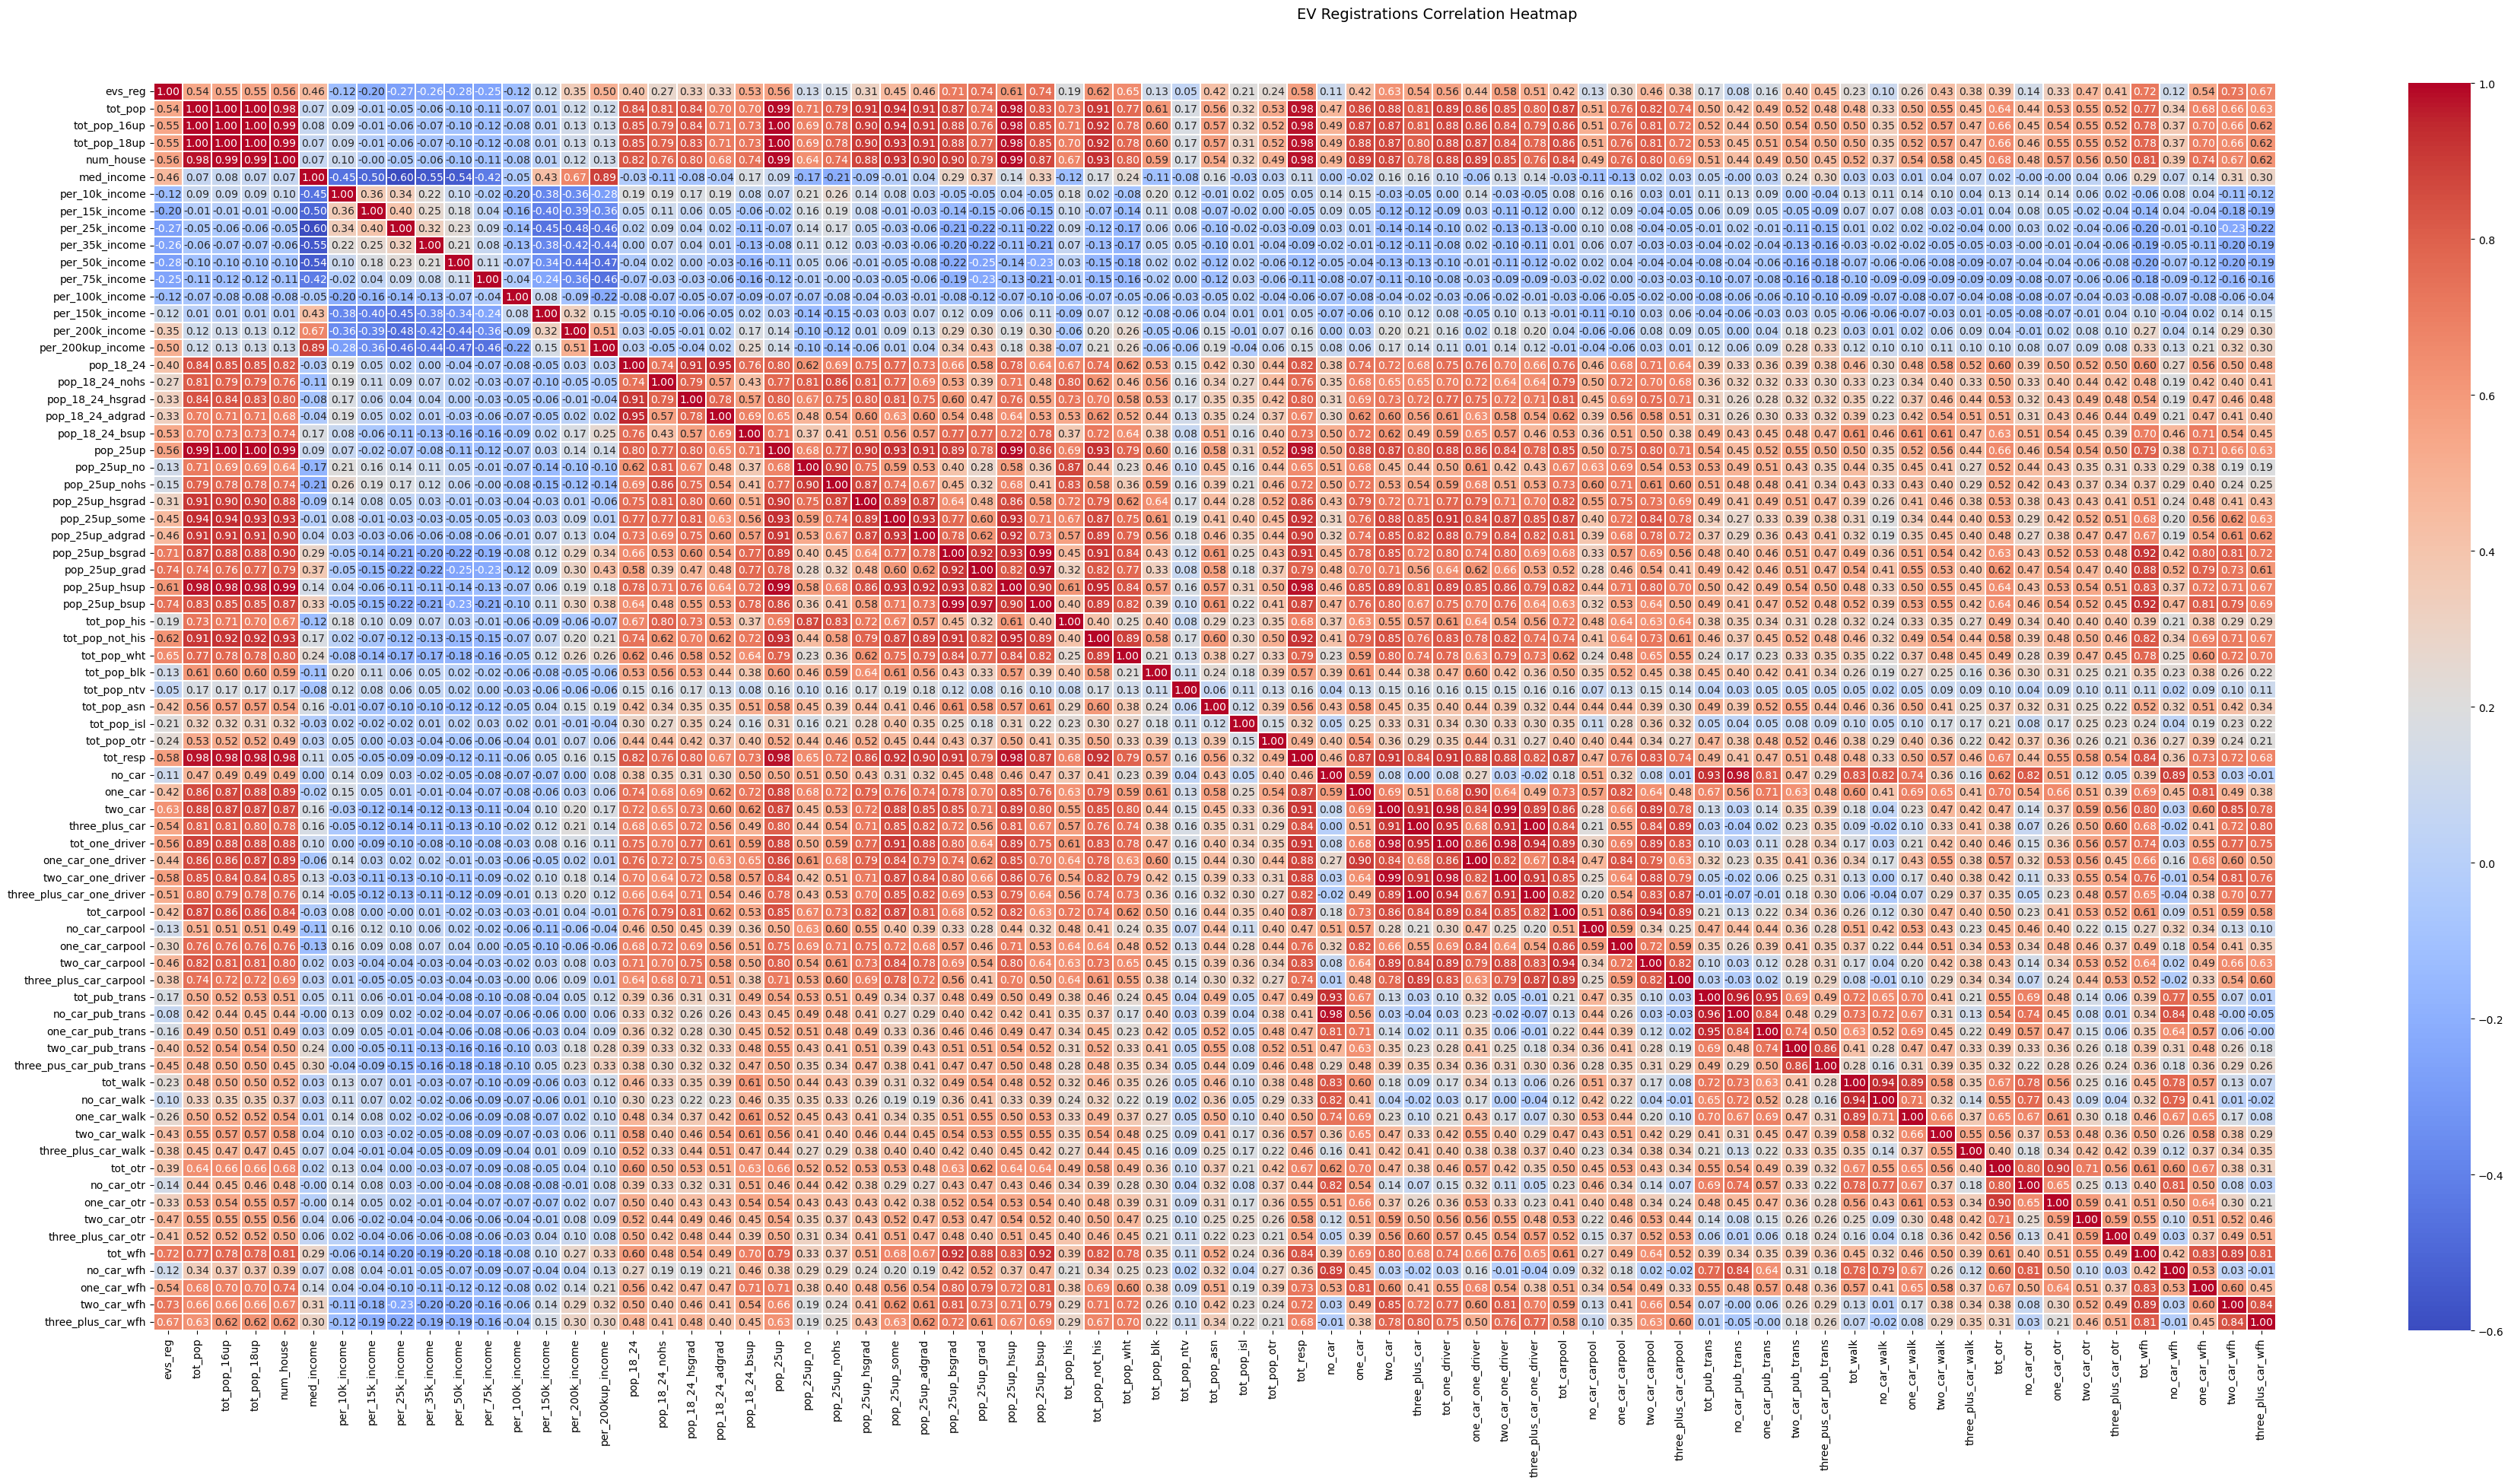

In [21]:
f,ax = plt.subplots(figsize=(45,20))
corr = train_data.corr(numeric_only=True)
heat_map = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('EV Registrations Correlation Heatmap', fontsize=14)

In [5]:
#sns.pairplot(train_data, diag_kind='kde')

#### Visualize the spread of data. <br>

Note that metrics like **tot_pop** have much greater values and ranges that other metrics like **per_10k_income**. This requires that the data be normalized if features have different scales and ranges.

In [24]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
evs_reg,6146.0,108.422226,198.641325,1.0,5.00,26.0,121.00,3294.0
tot_pop,6146.0,14199.340709,17446.670266,16.0,1919.50,6643.0,21135.50,130352.0
tot_pop_16up,6146.0,11306.537423,13672.662452,16.0,1582.00,5400.0,16994.25,90435.0
tot_pop_18up,6146.0,10928.932802,13211.430949,16.0,1527.25,5222.5,16539.50,87042.0
num_house,6146.0,5308.617149,6365.650140,10.0,757.00,2519.5,8071.00,41418.0
...,...,...,...,...,...,...,...,...
tot_wfh,6146.0,503.898796,807.173280,0.0,48.00,172.0,613.50,10812.0
no_car_wfh,6146.0,34.980312,214.322801,0.0,0.00,0.0,7.00,4769.0
one_car_wfh,6146.0,107.460462,217.436473,0.0,1.00,24.0,108.75,3045.0
two_car_wfh,6146.0,217.716726,383.034562,0.0,15.00,66.0,245.00,5188.0


#### Split features from labels

In [25]:
train_features = train_data.copy()
train_labels = train_features.pop('evs_reg')

test_features  = test_data.copy()

### Linear regression with one feature (total population)

In [4]:
# extract one variable
population = np.array(train_features['tot_pop'])

# normalize the variable 
population_normalizer = layers.Normalization(input_shape = [1,],axis = None)
population_normalizer.adapt(population)

# define model structure
population_model = tf.keras.Sequential([
    population_normalizer,
    layers.Dense(units=1,activation = 'relu')
])

# build model
population_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=tf.losses.MeanSquaredError())

# fit model to training data, with 20% cross validation split 
history = population_model.fit(train_features['tot_pop'],
                    train_labels,
                    epochs=100,
                    validation_split = 0.2)

Epoch 1/100
155/155 [==============================] - 1s 2ms/step - loss: 36691.1133 - val_loss: 90438.3906
Epoch 2/100
155/155 [==============================] - 0s 952us/step - loss: 32531.4395 - val_loss: 83521.3672
Epoch 3/100
155/155 [==============================] - 0s 983us/step - loss: 29315.2480 - val_loss: 77888.2969
Epoch 4/100
155/155 [==============================] - 0s 947us/step - loss: 26859.3320 - val_loss: 73242.0078
Epoch 5/100
155/155 [==============================] - 0s 932us/step - loss: 25059.3711 - val_loss: 69445.6875
Epoch 6/100
155/155 [==============================] - 0s 889us/step - loss: 23762.6406 - val_loss: 66436.9922
Epoch 7/100
155/155 [==============================] - 0s 969us/step - loss: 22850.6914 - val_loss: 64081.3086
Epoch 8/100
155/155 [==============================] - 0s 929us/step - loss: 22241.0801 - val_loss: 62161.8125
Epoch 9/100
155/155 [==============================] - 0s 968us/step - loss: 21843.4375 - val_loss: 60794.6250
Epo

#### Plot loss
Using total population alone underfits the data. Denoted by a large gap between loss and cross validation loss 

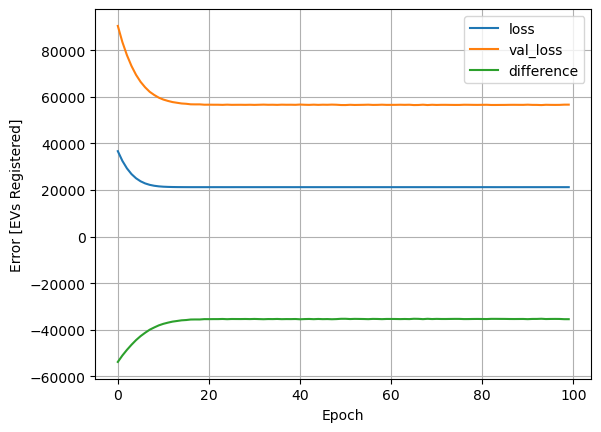

In [5]:
plot_loss(history)

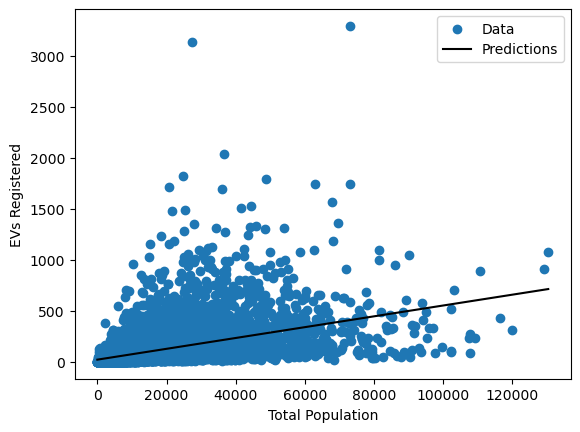

Predicted EVs Registered = 92.59*total population + 98.56


In [8]:
x = tf.linspace(0, 130352, 1000)
y = population_model.predict(x,
                             verbose=0)
plot_totpop(x, y)
plt.show()

weights = population_model.layers[1].get_weights()[0][0][0]
bias    = population_model.layers[1].get_weights()[1][0]

print(f"Predicted EVs Registered = {weights:.2f}*total population + {bias:.2f}")

### Linear regression with 3 variables (total population, number of households, median income)

In [9]:
# extract three variables
three_var = np.array(train_features[['tot_pop','num_house','med_income']])

# normalize each variable
three_var_normalizer = layers.Normalization(input_shape = [3,],axis = None)
three_var_normalizer.adapt(three_var)

# define model structure
three_var_model = tf.keras.Sequential([
    three_var_normalizer,
    layers.Dense(units=1)
])

# build model
three_var_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=tf.losses.MeanSquaredError())

# fit model to training data, with 20% cross validation split 
history_three_var = three_var_model.fit(np.array(train_features[['tot_pop','num_house','med_income']]),
                                        train_labels,
                                        epochs=100,
                                        validation_split = 0.2)



Epoch 1/100
155/155 [==============================] - 0s 1ms/step - loss: 35290.1953 - val_loss: 88060.1406
Epoch 2/100
155/155 [==============================] - 0s 744us/step - loss: 29422.1504 - val_loss: 80338.1250
Epoch 3/100
155/155 [==============================] - 0s 706us/step - loss: 25850.3223 - val_loss: 74793.3750
Epoch 4/100
155/155 [==============================] - 0s 777us/step - loss: 23386.5566 - val_loss: 70469.8516
Epoch 5/100
155/155 [==============================] - 0s 676us/step - loss: 21522.8457 - val_loss: 67116.5703
Epoch 6/100
155/155 [==============================] - 0s 765us/step - loss: 20052.4434 - val_loss: 64251.3047
Epoch 7/100
155/155 [==============================] - 0s 751us/step - loss: 18871.5645 - val_loss: 61793.1211
Epoch 8/100
155/155 [==============================] - 0s 751us/step - loss: 17926.2812 - val_loss: 59912.4453
Epoch 9/100
155/155 [==============================] - 0s 732us/step - loss: 17158.7266 - val_loss: 58145.8516
Epo

#### Plot three variable model loss
Using three variables provides a better model than total population alone, but still underfits the data. Denoted by a large gap between loss and cross validation loss 

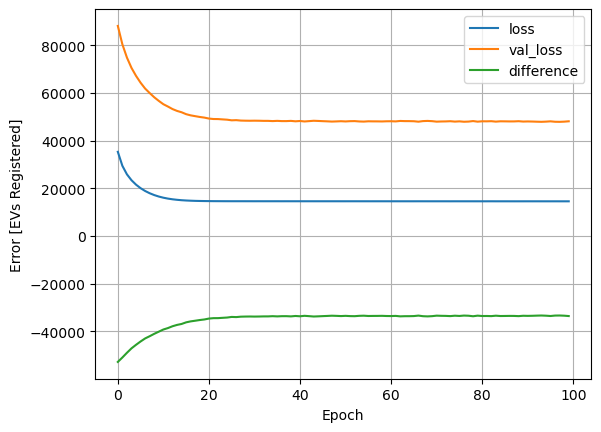

In [10]:
plot_loss(history_three_var)

### Linear regression with all variables

In [11]:
# normalize each variable
normalizer = layers.Normalization(input_shape = [30,],axis = None)
normalizer.adapt(train_features)

# define model structure
all_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1, activation='relu')
])

# build model
all_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=tf.losses.MeanSquaredError())

# fit model to training data, with 20% cross validation split 
history_all_var = all_model.fit(np.array(train_features),
                                        train_labels,
                                        epochs=100,
                                        validation_split = 0.2)

Epoch 1/100
155/155 [==============================] - 0s 2ms/step - loss: 26021.1172 - val_loss: 59010.3789
Epoch 2/100
155/155 [==============================] - 0s 1ms/step - loss: 17522.9434 - val_loss: 50144.2617
Epoch 3/100
155/155 [==============================] - 0s 872us/step - loss: 15681.0703 - val_loss: 47039.5273
Epoch 4/100
155/155 [==============================] - 0s 947us/step - loss: 14674.1621 - val_loss: 44400.8711
Epoch 5/100
155/155 [==============================] - 0s 955us/step - loss: 13965.8701 - val_loss: 44199.6953
Epoch 6/100
155/155 [==============================] - 0s 979us/step - loss: 13445.5703 - val_loss: 43600.8867
Epoch 7/100
155/155 [==============================] - 0s 921us/step - loss: 13000.7676 - val_loss: 41750.7383
Epoch 8/100
155/155 [==============================] - 0s 941us/step - loss: 12699.7129 - val_loss: 41966.6289
Epoch 9/100
155/155 [==============================] - 0s 939us/step - loss: 12432.0889 - val_loss: 39894.4180
Epoch

#### Plot all variable model loss

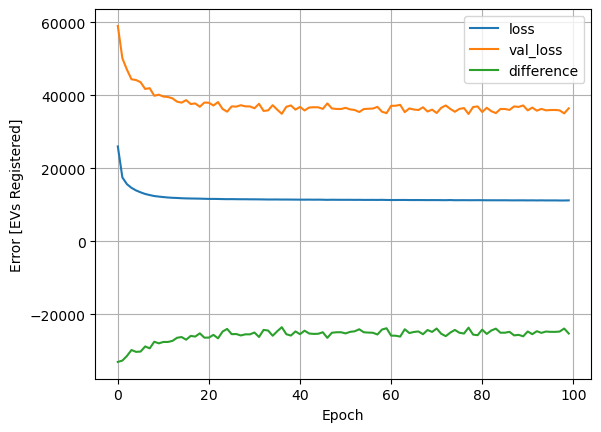

In [12]:
plot_loss(history_all_var)

>2 -1.227 (0.171)
>4 -1.263 (0.145)
>6 -1.150 (0.115)
>8 -1.151 (0.162)
>10 -1.151 (0.117)
>12 -1.143 (0.171)
>14 -1.105 (0.080)
>16 -1.107 (0.106)
>18 -1.064 (0.125)
>20 -1.085 (0.096)
>22 -1.091 (0.101)
>24 -1.068 (0.093)
>26 -1.079 (0.120)
>28 -1.068 (0.073)


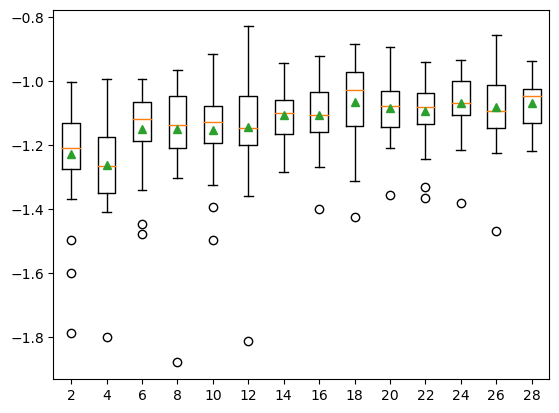

In [15]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

# data set
X = np.array(train_features)
y = np.array(train_labels)

# scale data set
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# split data set
X_train, X_test, y_train, y_test = train_test_split(X_norm, y,
                                                    test_size = 0.3,
                                                    random_state = 1)

# define list of models to evaluate
def get_model():
    models = dict()
    for i in range(2,29,2):
        rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=i)
        model = DecisionTreeRegressor()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a given model using cross-validation
def evaluate_model(model,X,y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X,y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=1, error_score='raise')
    return scores

models = get_model()
results, names = list(), list()

for name, model in models.items():
    scores = evaluate_model(model, X_norm, y)
    results.append(scores)
    names.append(name)      
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# sgdr = SGDRegressor(max_iter=1000)
# sgdr.fit(X_train,y_train)

# importance = sgdr.coef_
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' %(i,v))

#### Feature Selection

Objective: Using a Random Forest Classifier, with 100 "trees" in each forest, select the top 10 features that can be used to describe this data set.

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

X = train_features
y = train_labels

# scale data set
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

X_norm_df = pd.DataFrame(X_norm, index=X.index, columns=X.columns)

# # split data set
X_train, X_test, y_train, y_test = train_test_split(X_norm_df, y,
                                                    test_size = 0.3,
                                                    random_state = 1)

rfe_method = RFE(RandomForestClassifier(n_estimators=100,random_state=10),
                 n_features_to_select=10,
                 step=1,
                 verbose=1)

rfe_method.fit(X_train,y_train)

X_train.columns[(rfe_method.get_support())]


Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 fe

Index(['med_income', 'per_50k_income', 'pop_25up_adgrad', 'pop_25up_grad',
       'pop_25up_bsup', 'tot_pop_his', 'tot_pop_wht', 'tot_pop_asn', 'm2f_per',
       'tot_wfh'],
      dtype='object')

We find that these variables are the top 10:

| Variable List | Description |
| :- | --- |
| med_income | median income by household |
| per_50k_income | \% of Households Earning \\$35,000 to \\$49,999 |
| pop_25up_adgrad | 25 years and over - Associate's degree |
| pop_25up_grad | 25 years and over - Graduate or professional degree |
| pop_25up_bsup | 25 years and over - Bachelor's degree or higher |
| tot_pop_his | total hispanic (1 race) population |
| tot_pop_wht | total white (1 race) population |
| tot_pop_asn | total asian (1 race) population |
| m2f_per | male to female percent within total population |
| tot_wfh | total people working from home |

Lets take the top 10 variables and condense them down to the top 4.

In [39]:
X = train_features[['med_income', 'per_50k_income', 'pop_25up_adgrad', 'pop_25up_grad', 'pop_25up_bsup', 'tot_pop_his', 'tot_pop_wht','tot_pop_asn', 'm2f_per','tot_wfh']]
y = train_labels

# scale data set
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

X_norm_df = pd.DataFrame(X_norm, index=X.index, columns=X.columns)

# # split data set
X_train, X_test, y_train, y_test = train_test_split(X_norm_df, y,
                                                    test_size = 0.3,
                                                    random_state = 1)

rfe_method = RFE(RandomForestClassifier(n_estimators=100,random_state=10),
                 n_features_to_select=4,
                 step=1,
                 verbose=1)

rfe_method.fit(X_train,y_train)

X_train.columns[(rfe_method.get_support())]

for i in range(X_train.shape[1]):
    print('Variable: %s, Top 4? %s, Rank: %d' % (X_train.columns[i], rfe_method.support_[i], rfe_method.ranking_[i]))

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Variable: med_income, Top 4? True, Rank: 1
Variable: per_50k_income, Top 4? False, Rank: 6
Variable: pop_25up_adgrad, Top 4? False, Rank: 2
Variable: pop_25up_grad, Top 4? True, Rank: 1
Variable: pop_25up_bsup, Top 4? True, Rank: 1
Variable: tot_pop_his, Top 4? False, Rank: 4
Variable: tot_pop_wht, Top 4? True, Rank: 1
Variable: tot_pop_asn, Top 4? False, Rank: 7
Variable: m2f_per, Top 4? False, Rank: 5
Variable: tot_wfh, Top 4? False, Rank: 3


We find that these variables are the top 4:

| Variable List | Description |
| :- | --- |
| med_income | median income by household |
| pop_25up_grad | 25 years and over - Graduate or professional degree |
| pop_25up_bsup | 25 years and over - Bachelor's degree or higher |
| tot_pop_wht | total white (1 race) population |

### Linear regression with top 4 variables

In [45]:
# extract four variables
four_var = np.array(train_features[['med_income','pop_25up_grad','pop_25up_bsup','tot_pop_wht']])

# normalize each variable
four_var_normalizer = layers.Normalization(input_shape = [4,],axis = None)
four_var_normalizer.adapt(four_var)

# define model structure
four_var_model = tf.keras.Sequential([
    four_var_normalizer,
    layers.Dense(units=1,activation='relu')
])

# build model
four_var_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.losses.MeanSquaredError())

# fit model to training data, with 20% cross validation split 
history_four_var = four_var_model.fit(four_var,
                                      train_labels,
                                      epochs=500,
                                      validation_split = 0.2)

Epoch 1/500
154/154 [==============================] - 1s 2ms/step - loss: 38691.9961 - val_loss: 96914.2734
Epoch 2/500
154/154 [==============================] - 0s 987us/step - loss: 37507.6992 - val_loss: 95391.3203
Epoch 3/500
154/154 [==============================] - 0s 902us/step - loss: 36466.3477 - val_loss: 93978.6641
Epoch 4/500
154/154 [==============================] - 0s 896us/step - loss: 35534.4570 - val_loss: 92676.4219
Epoch 5/500
154/154 [==============================] - 0s 847us/step - loss: 34686.2812 - val_loss: 91454.1172
Epoch 6/500
154/154 [==============================] - 0s 897us/step - loss: 33910.7695 - val_loss: 90306.7656
Epoch 7/500
154/154 [==============================] - 0s 932us/step - loss: 33204.0000 - val_loss: 89241.1641
Epoch 8/500
154/154 [==============================] - 0s 982us/step - loss: 32556.3477 - val_loss: 88203.8125
Epoch 9/500
154/154 [==============================] - 0s 905us/step - loss: 31959.6035 - val_loss: 87230.5469
Epo

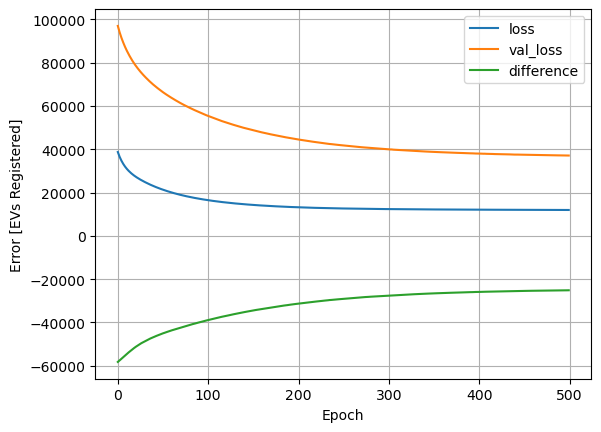

Predicted EVs Registered = 94.03*med_income + -13.91*pop_25up_grad + 257.23*pop_25up_bsup + 298.59*tot_pop_wht + 166.94


In [46]:
plot_loss(history_four_var)
plt.show()

weights = np.ones([4,1])
for i in range(4):
    weights[i,:] = four_var_model.layers[1].get_weights()[0][i][0]

bias    = four_var_model.layers[1].get_weights()[1][0]

# don't actually know if these variables go with these coefficients?
print(f"Predicted EVs Registered = {weights[0][0]:.2f}*med_income + {weights[1][0]:.2f}*pop_25up_grad + {weights[2][0]:.2f}*pop_25up_bsup + {weights[3][0]:.2f}*tot_pop_wht + {bias:.2f}")

<a name='0'></a>
## Note - Limitations of spatial analysis using ZIP codes
Contrary to common belief, ZIP codes **do not** represent geographical areas, but correspond to mail delivery routes. Some problems using ZIP codes as geospatial units include:<br>
- overlapping geographical areas,<br>
- spatial subsets of geographical areas,<br>
- constructs with no physical address (such as 00095, which represents mail for the Navy),<br>
- rural areas without postal routes or underdeveloped areas with no mail delivery, and <br>
- frequent realigns, merges, or splits by the United States Postal Service to meet changing needs.

As a consequence, ZIP codes are not the ideal form of spatial representation for human behavior. So why do we continue to use them? Simply put, ZIP codes are familiar to the general population, easily collected for data analysis, and most importantly: *may be the only geospatial unit that a business has to work with*. 

More ideal measures, such as [ZIP code tabulation areas (ZCTAs)](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html) (generalized area representations of ZIP code service areas) or [Census Block Groups](https://www.census.gov/geographies/reference-maps/2020/geo/2020-census-block-maps.html) (the smallest geospatial area the Burea of the Census collects), are less familiar to the general population. For further information, I recommend reading [Stop using Zip Codes for GeoSpatial analysis](https://carto.com/blog/zip-codes-spatial-analysis) for examples of real-world complications of using ZIP codes, but more importantly, for useful tips for utlizing more accurate geospatial metrics.

In the case of our dataset, vehicle registration is currently aggregated on the ZIP level, but may provide a useful "jumping off" point until vehicle registrations are further refined in the future.